In [39]:
from pathlib import Path
import PIL
import matplotlib.pyplot as plt
import numpy as np
from ruamel.yaml import YAML
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import importlib.resources as pkg_resources
import seaborn as sns
import numpy.typing as npt

# from topostats.io import save_topostats_file
# from topostats.grains import Grains, GrainCrop, GrainCropsDirection, ImageGrainCrops
# from topostats.processing import run_grainstats
# from topostats.io import read_yaml
# import topostats

base_dir = Path("/Users/sylvi/topo_data/perovskites-mountains")
assert base_dir.exists()
data_dir = base_dir / "freqsplit"
assert data_dir.exists()

testdir = data_dir / "cutoff_freq_nm-225" / "1st samples- just retrace - 1-2um pyramids" / "C60 data"

config_yaml_files = list(testdir.glob("*_config.yaml"))

nm_to_micron = 1e-3

In [ ]:
# yaml = YAML()
# config_topostats = read_yaml(Path("./topostats") / "default_config.yaml")
# plotting_dictionary = Path("./topostats/plotting_dictionary.yaml")
# config_topostats["plotting"]["plot_dict"] = read_yaml(plotting_dictionary)
# config_plotting = config_topostats["plotting"]

# # construct topostats file

# topostats_dict = {}
# topostats_dict["image_original"] = raw_image
# topostats_dict["image"] = processed_image
# # topostats_dict["mask"]
# grain_mask_tensor_background = np.zeros_like(mask)
# grain_mask_tensor = np.stack(
#     [
#         grain_mask_tensor_background,
#         mask,
#     ],
#     axis=-1,
# )
# Grains.update_background_class(grain_mask_tensor)

# topostats_dict["grain_tensors"] = {"above": grain_mask_tensor}
# # add yaml data as metadata
# yaml = YAML()
# with mask_yaml_file.open("r") as f:
#     mask_yaml = yaml.load(f)
# topostats_dict["mask_metadata"] = mask_yaml
# with config_yaml_file.open("r") as f:
#     config_yaml = yaml.load(f)
# topostats_dict["image_metadata"] = config_yaml

# pixel_to_nm_scaling = config_yaml["pixel_to_nm_scaling"]

# graincrops = Grains.extract_grains_from_full_image_tensor(
#     image=processed_image,
#     full_mask_tensor=grain_mask_tensor,
#     padding=10,
#     pixel_to_nm_scaling=pixel_to_nm_scaling,
#     filename=filename,
# )

# print(f"Extracted {len(graincrops)} grains")

# graincropsdirection = GrainCropsDirection(
#     crops=graincrops,
#     full_mask_tensor=grain_mask_tensor,
# )

# imagegraincrops = ImageGrainCrops(
#     above=graincropsdirection,
#     below=None,
# )

# # run grainstats
# grainstats_df, height_profiles = run_grainstats(
#     image_grain_crops=imagegraincrops,
#     filename=filename,
#     basename=file_directory,
#     grainstats_config={"run": True},
#     plotting_config=config_plotting,
#     grain_out_path=file_directory,
# )

# save_topostats_file(output_dir=testdir, filename=f"{filename}.topostats", topostats_object=topostats_dict)

# break

In [49]:
def plot_areas(areas: list, title: str | None = None, units: str = "um") -> None:
    if title is None:
        title = ""
    title = title + f" n:{len(areas)}"
    plt.figure()
    if units == "um":
        areas = [area * nm_to_micron**2 for area in areas]
        plt.xlabel("area (µm²)")
    elif units == "nm":
        plt.xlabel("area (nm²)")
    else:
        raise ValueError("units must be 'um' or 'nm'")
    sns.histplot(areas, kde=True, bins="auto", log_scale=True)
    plt.title(title)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


def plot_mask_gallery(masks_data: dict[str, dict[str, npt.NDArray | float]], col_num: int = 3) -> None:
    num_rows = len(masks_data) // col_num + 1

    fig, ax = plt.subplots(num_rows, col_num, figsize=(10 * col_num, 10 * num_rows))
    i = 0
    for filename, mask_data in masks_data.items():
        mask_rgb = mask_data["mask_rgb"]
        row = i // col_num
        col = i % col_num
        ax[row, col].imshow(mask_rgb, cmap="gray")
        ax[row, col].set_title(f"{filename}")
        i += 1
    plt.tight_layout()
    plt.show()

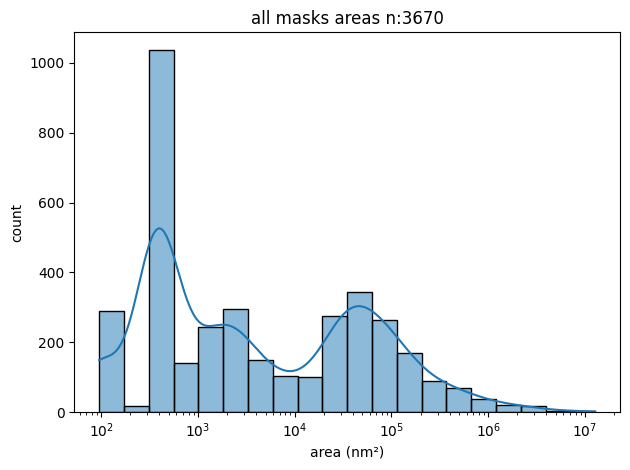

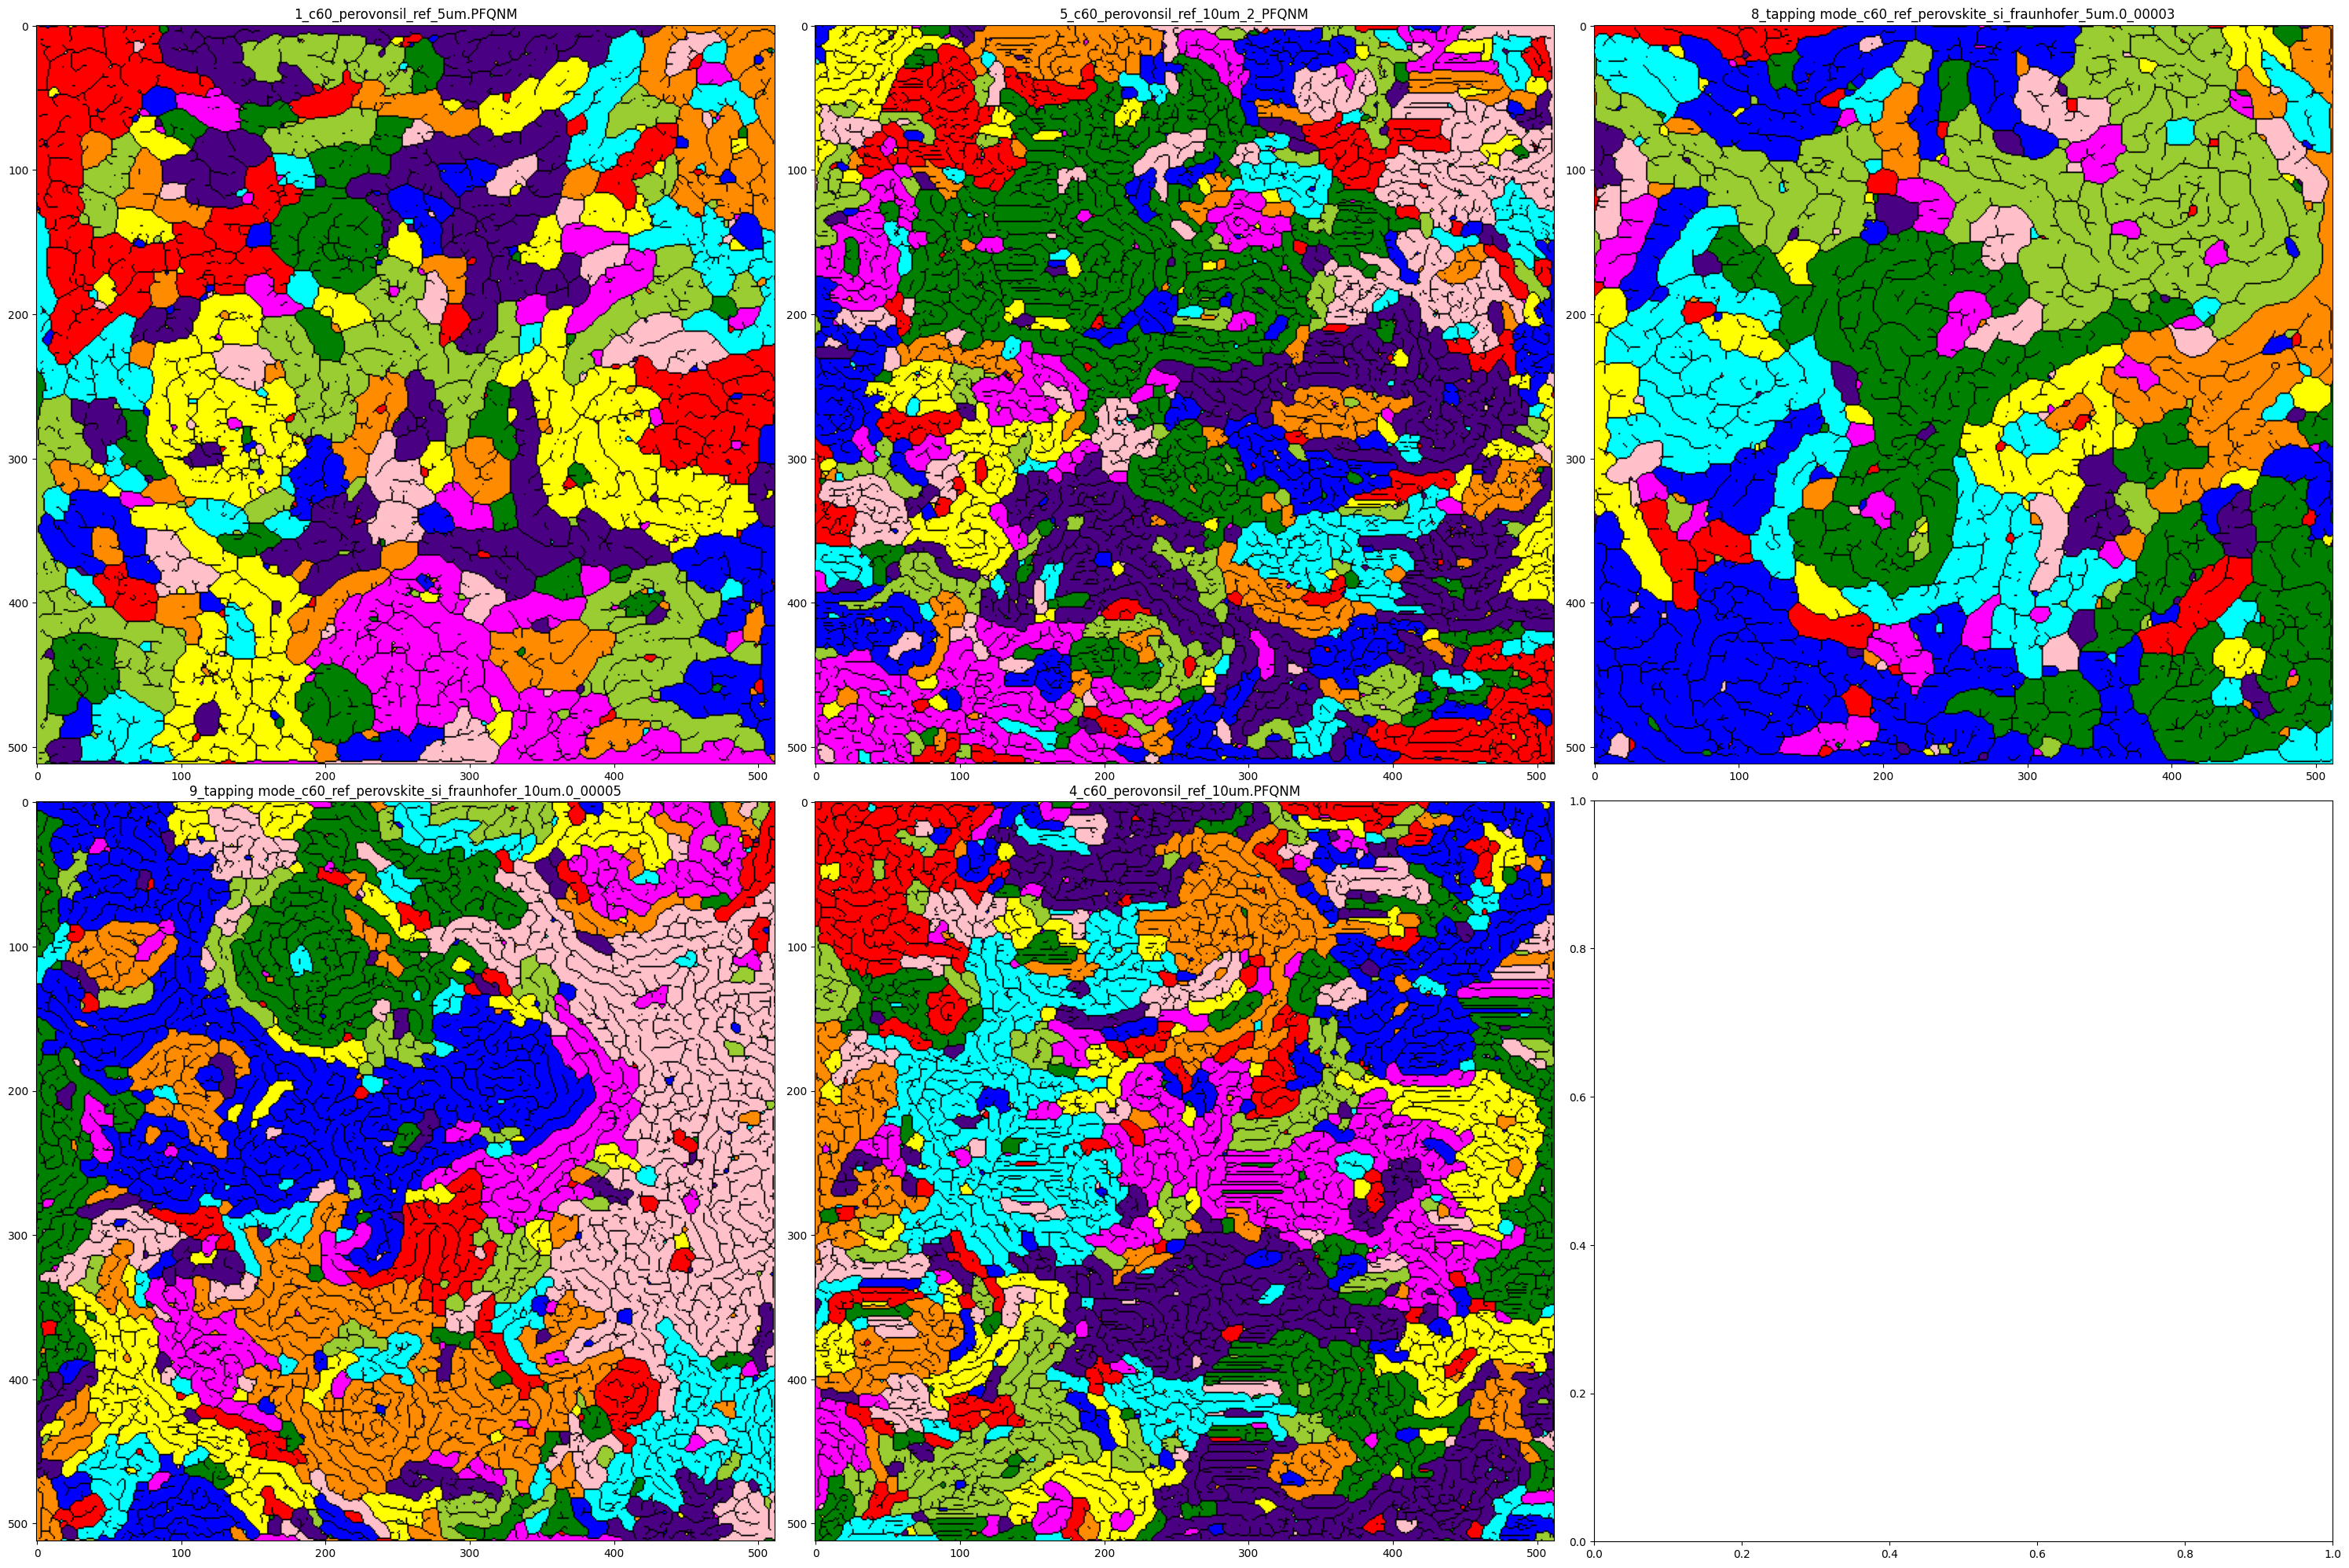

In [ ]:
all_masks_grain_areas = []
all_masks_data = {}

for config_yaml_file in config_yaml_files:
    filename = config_yaml_file.stem
    file_directory = testdir
    # strip off the _config
    filename = filename[:-7]
    # print(filename)

    filename_files = list(testdir.glob(f"{filename}*"))
    # for filename_file in filename_files:
    #     print(filename_file)

    # add yaml data as metadata
    yaml = YAML()
    with mask_yaml_file.open("r") as f:
        mask_yaml = yaml.load(f)
    with config_yaml_file.open("r") as f:
        config_yaml = yaml.load(f)

    pixel_to_nm_scaling = config_yaml["pixel_to_nm_scaling"]

    raw_image_file = testdir / f"{filename}_original.npy"
    assert raw_image_file.exists()
    processed_image_file = testdir / f"{filename}_high_pass.npy"
    assert processed_image_file.exists()
    mask_file = testdir / f"{filename}_mask.npy"
    assert mask_file.exists()
    mask_yaml_file = testdir / f"{filename}_mask.yaml"
    assert mask_yaml_file.exists()

    raw_image = np.load(raw_image_file)
    processed_image = np.load(processed_image_file)
    mask = np.load(mask_file).astype(bool)
    mask = np.invert(mask)
    labelled_mask = label(mask, connectivity=1)
    labelled_mask_rgb = label2rgb(labelled_mask, bg_label=0)

    # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # plt.imshow(labelled_mask_rgb)
    # plt.show()

    mask_regionprops = regionprops(labelled_mask)
    mask_areas = [regionprop.area * pixel_to_nm_scaling**2 for regionprop in mask_regionprops]
    # plot_areas(single_mask_areas, title=f"{filename} mask areas")
    all_masks_grain_areas.extend(mask_areas)

    mask_size_x = mask.shape[1] * pixel_to_nm_scaling
    mask_size_y = mask.shape[0] * pixel_to_nm_scaling
    mask_area_nm = mask_size_x * mask_size_y
    grains_per_nm2 = len(mask_areas) / mask_area_nm

    mask_data = {
        "mask_rgb": labelled_mask_rgb,
    }
    all_masks_data[filename] = mask_data

plot_areas(all_masks_grain_areas, title="all masks areas", units="nm")

plot_mask_gallery(all_masks_data, col_num=3)